In [1]:
from pathlib import Path
import time
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
import networkx as nx
from stochopy.optimize import minimize
from tqdm import tqdm
import similaritymeasures
import random
import matplotlib.pyplot as plt
from shapely.ops import Point, MultiLineString, LineString
from importlib import reload
import datetime
from scipy.spatial.distance import directed_hausdorff
np.set_printoptions(suppress=True)

from bikewaysim.paths import config, stadia_toner, maptiler_streets
from bikewaysim.impedance_calibration import stochastic_optimization, speedfactor
from bikewaysim.network import modeling_turns
from bikewaysim.routing import rustworkx_routing_funcs
from bikewaysim.impedance_calibration import optimization_viz, utils, post_calibration

from step_1_calibration_experiments import all_calibrations, full_model

## Post Validation
- Retrieve loss values for testing and training set for each fold
- Create confidence intervals of the betas from the bootstrapped results

## K-fold Results

In [2]:
loss_vals = post_calibration.aggregated_loss_dataframe()
training_loss_vals = loss_vals[loss_vals['subset'].str.contains('fold_') & (loss_vals['run_num'] == '0')]
testing_loss_vals = post_calibration.testing_aggregated_loss_dataframe()

In [3]:
# testing_loss_vals = testing_loss_vals.dropna()

cols = ['subset','jaccard_buffer_mean','shortest_jaccard_buffer_mean']
training_loss_vals = training_loss_vals[cols].sort_values('subset').set_index('subset')
training_loss_vals.columns = 'train_' + training_loss_vals.columns
testing_loss_vals = testing_loss_vals[cols].sort_values('subset').set_index('subset')
testing_loss_vals.columns = 'test_' + testing_loss_vals.columns

In [7]:
# print the results of each
print("Training Overlap Values:",str(training_loss_vals.sort_values('subset')['train_jaccard_buffer_mean'].tolist()))
print("Testing Overlap Values:",str(testing_loss_vals.sort_values('subset')['test_jaccard_buffer_mean'].tolist()))

# report the averages
print("Training Overlap Mean:",training_loss_vals['train_jaccard_buffer_mean'].mean().round(2))
print("Testing Overlap Mean:",testing_loss_vals['test_jaccard_buffer_mean'].mean().round(2))

Training Overlap Values: [0.46, 0.44, 0.46, 0.46, 0.46]
Testing Overlap Values: [0.44, 0.46, 0.41, 0.44, 0.46]
Training Overlap Mean: 0.46
Testing Overlap Mean: 0.44


In [27]:
kfold_results = pd.concat([training_loss_vals,testing_loss_vals],ignore_index=False,axis=1)
mean_row = kfold_results.mean().to_frame().T
mean_row.index = ['mean']
kfold_results = pd.concat([kfold_results,mean_row])
kfold_results.to_csv(config['scratch_fp']/'kfold_results.csv')
kfold_results

,train_jaccard_buffer_mean,train_shortest_jaccard_buffer_mean,test_jaccard_buffer_mean,test_shortest_jaccard_buffer_mean
fold_0,0.460,0.350,0.440,0.350
fold_1,0.440,0.370,0.460,0.370
fold_2,0.460,0.370,0.410,0.370
fold_3,0.460,0.350,0.440,0.350
fold_4,0.460,0.350,0.460,0.350
mean,0.456,0.358,0.442,0.358


## Bootstrapping Results

TypeError: cannot unpack non-iterable AxesSubplot object

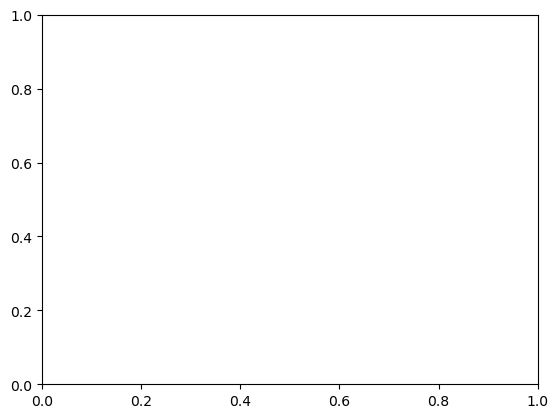

In [56]:
bootstrap_loss_vals = loss_vals[loss_vals['subset'].str.contains('boot')]
min_val = bootstrap_loss_vals['jaccard_buffer_mean'].min()
max_val = bootstrap_loss_vals['jaccard_buffer_mean'].max()

fig, ax = plt.subplot()
ax.hist(bootstrap_loss_vals['jaccard_buffer_mean'],bins=np.arange(min_val,max_val+0.01,0.01))
ax.set_title('Jaccard Buffer Mean')
ax.set_xlabel('Beta Value (Bin Size = 0.01)')
ax.set_ylabel('Frequency')

In [28]:
# import all of the betas
beta_vals = post_calibration.betas_dataframe()

# only want the bootstrap results
beta_vals = beta_vals[beta_vals['subset'].str.contains('bootsample')].dropna(axis=1,how='all')

In [34]:
# get the beta statistics
betas = ['2lpd','3+lpd','(30,inf) mph','[4,6) grade','[6,inf) grade','bike lane','cycletrack','multi use path','unsig_crossing','left_turn','right_turn']
beta_labels = ['2 Lanes per Direction','3+ Lanes per Direction','> 30 MPH','[4%,6%) Grade','> 6% Grade','Bike Lane','Cycletrack','Multi-Use Path','Unsignalized','Left Turn','Right Turn']
beta_vals[betas].describe().round(2)

,2lpd,3+lpd,"(30,inf) mph","[4,6) grade","[6,inf) grade",bike lane,cycletrack,multi use path,unsig_crossing,left_turn,right_turn
count,489.00,489.00,489.00,489.00,489.00,489.00,489.00,489.00,489.00,489.00,489.00
mean,0.18,0.91,0.36,0.88,1.88,-0.48,-0.50,-0.39,1.19,0.72,0.74
std,0.24,0.42,0.16,0.48,0.98,0.15,0.28,0.10,0.62,0.33,0.28
min,-0.26,0.12,-0.15,-0.12,-0.10,-0.86,-0.99,-0.81,0.01,0.01,0.09
25%,-0.00,0.59,0.24,0.54,1.16,-0.59,-0.69,-0.44,0.75,0.49,0.55
50%,0.12,0.85,0.37,0.87,1.82,-0.48,-0.54,-0.37,1.12,0.68,0.72
75%,0.32,1.13,0.47,1.18,2.41,-0.37,-0.32,-0.32,1.53,0.93,0.90
max,1.04,2.32,0.83,2.51,7.08,-0.04,2.31,-0.16,5.09,1.74,1.77


In [30]:
mean = beta_vals[betas].mean()
se = beta_vals[betas].std()
lower_bound_ci = beta_vals[betas].quantile(0.025)
upper_bound_ci = beta_vals[betas].quantile(1-0.025)
bootstrap_result = pd.concat([mean,se,lower_bound_ci,upper_bound_ci],axis=1,ignore_index=False)
bootstrap_result.columns = ['mean','standard_error','lower_bound_ci','upper_bound_ci']
bootstrap_result = bootstrap_result.round(2)
bootstrap_result.to_csv(config['scratch_fp']/'bootstrap_result.csv')

Make histograms of the different distributions?

In [62]:
beta_vals[betas].min().min()

-0.993

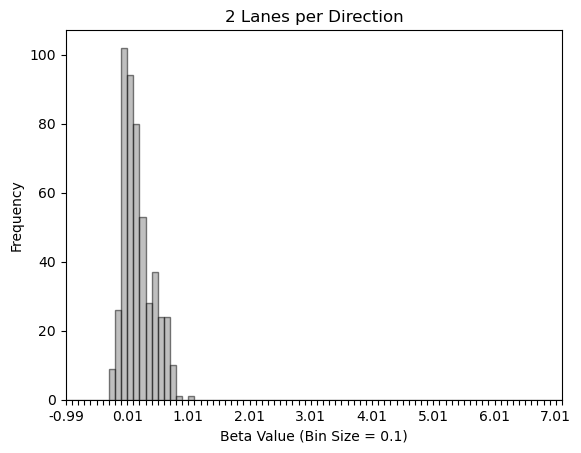

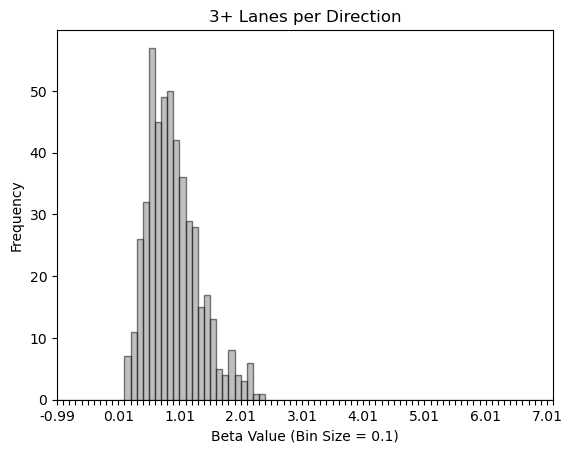

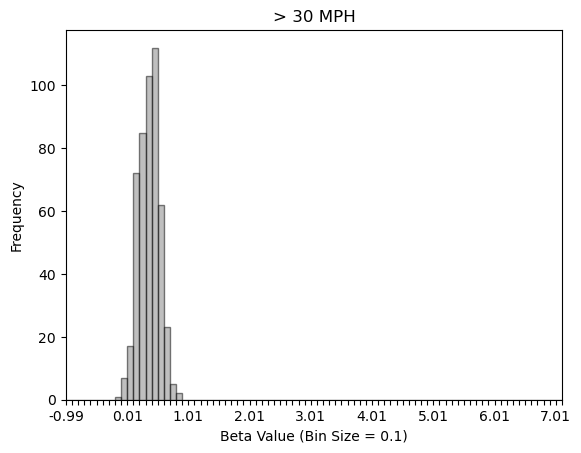

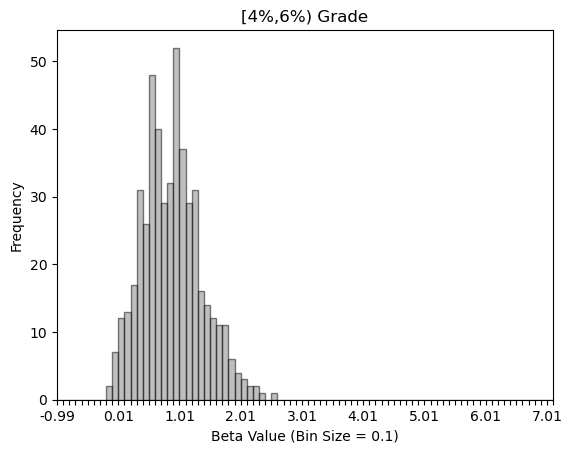

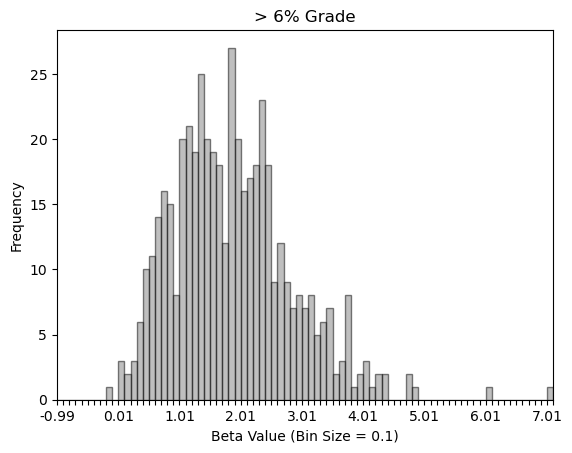

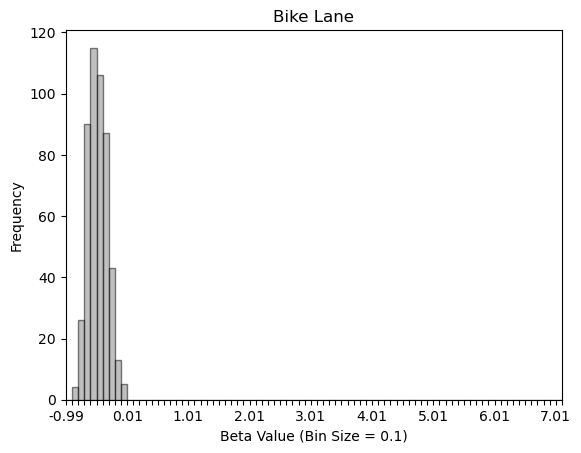

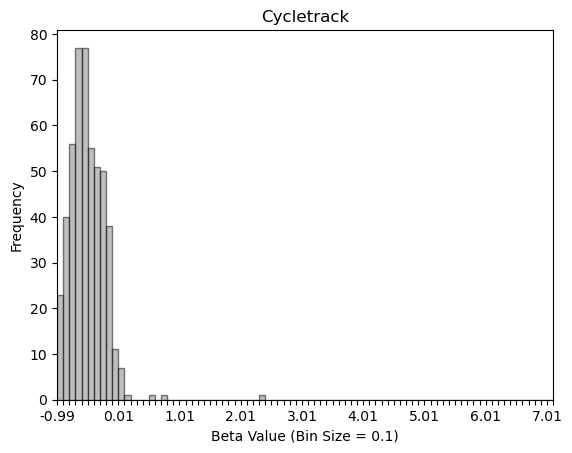

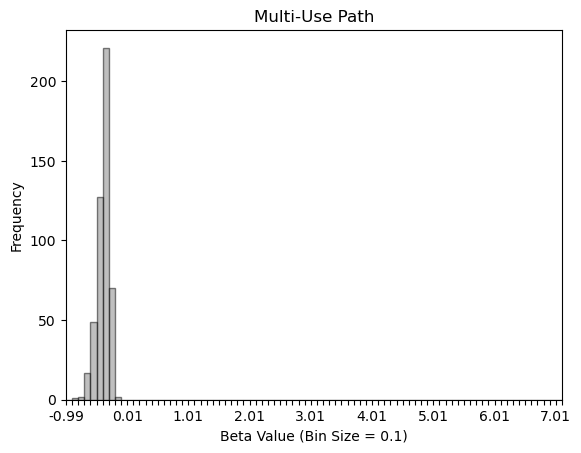

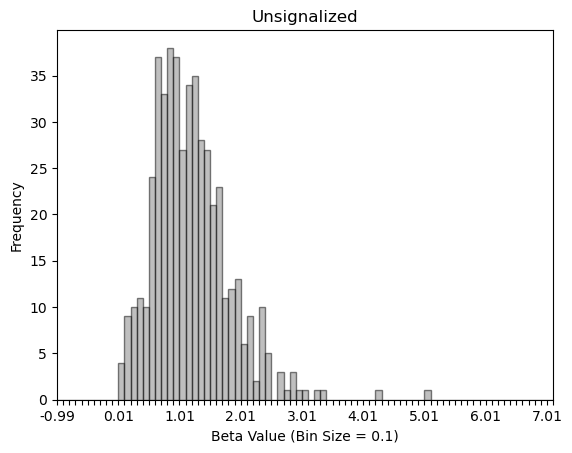

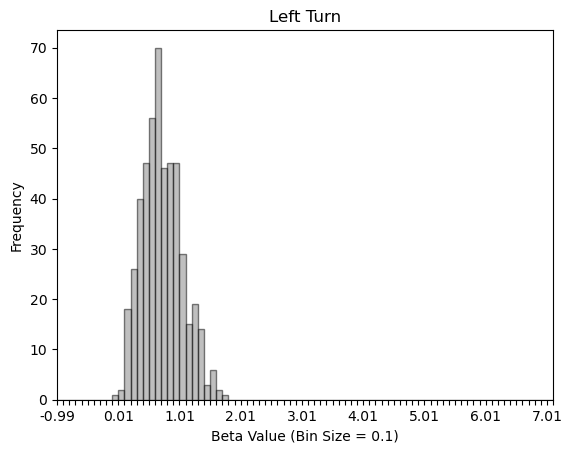

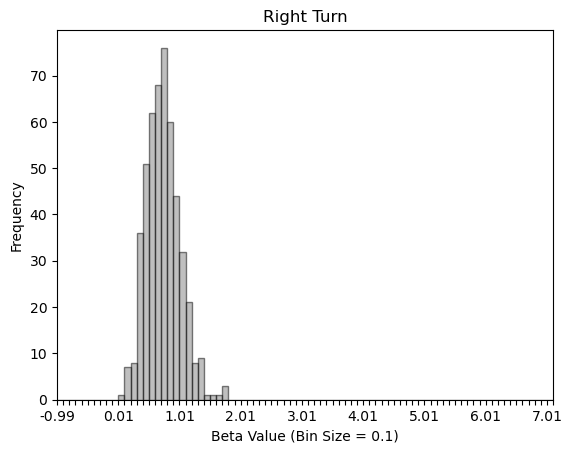

In [65]:
# Plot histogram for chosen_minus_modeled
min_val = beta_vals[betas].min().min()
max_val = beta_vals[betas].max().max()
bin_size = 0.1

for beta, label in zip(betas,beta_labels):
    fig, ax = plt.subplots()
    

    ax.hist(beta_vals[beta], bins=np.arange(min_val, max_val + bin_size, bin_size), alpha=0.5, color='grey', label=label, edgecolor='Black')
    ax.set_title(label)
    ax.set_xlabel(f'Beta Value (Bin Size = {bin_size})')
    ax.set_ylabel(f'Frequency (N={beta_vals.shape[0]})')
    ax.set_xlim(min_val,max_val)

    # Add vertical lines for the search limits with labels
    # for limit, lim_label in zip(search_limits, limit_labels):
    #     ax.axvline(x=limit, color='red', linestyle='--')
    #     ax.text(limit, ax.get_ylim()[1] * 0.9, lim_label, color='red', ha='center')

    # Set x-axis ticks with 0.05 increments from min to max
    ticks = np.arange(min_val, max_val + bin_size, bin_size)
    ax.set_xticks(ticks)
    ax.set_xticklabels([f"{tick:.2f}" if i % 10 == 0 else '' for i, tick in enumerate(ticks)])


    # Add vertical lines for the search limits
    # plt.savefig(config['figures_fp']/f"{beta}_bootstrap_dist.png")


In [ ]:
import matplotlib.pyplot as plt

# Define the number of columns to plot
columns = chosen_minus_modeled.columns  # Assuming both DataFrames have the same columns
num_columns = len(columns)

# Set up the figure and subplots
fig, axes = plt.subplots(num_columns, 1, figsize=(10, 100))

# Loop through each column and create a histogram
for i, column in enumerate(columns):
    # Plot histogram for chosen_minus_modeled
    axes[i].hist(chosen_minus_modeled[column].round(2), bins=50, alpha=0.5, color='blue', label='Chosen Minus Modeled', edgecolor='black')

    # Plot histogram for chosen_minus_shortest
    axes[i].hist(chosen_minus_shortest[column].round(2), bins=50, alpha=0.5, color='orange', label='Chosen Minus Shortest', edgecolor='black')

    # Set the title and labels for each subplot
    axes[i].set_title(f'Histogram for {column}')
    axes[i].set_ylabel('Frequency')
    
    # Center the histograms around zero by setting limits
    max_val = max(chosen_minus_modeled[column].max(), chosen_minus_shortest[column].max())
    min_val = min(chosen_minus_modeled[column].min(), chosen_minus_shortest[column].min())
    val = max(abs(max_val),abs(min_val))

    axes[i].set_xlim(min(val * -1, -1), max(val, 1))  # Adjust these limits based on your data

    # Add gridlines for better readability
    axes[i].grid(True)

    axes[i].legend()

# Set a common xlabel
axes[-1].set_xlabel('Value')

# Add a legend to the last subplot
# axes[-1].legend()

# Show the plot
plt.tight_layout()  # Adjust subplots to fit in the figure area.
plt.show()


array([[<AxesSubplot: title={'center': '2lpd'}>]], dtype=object)

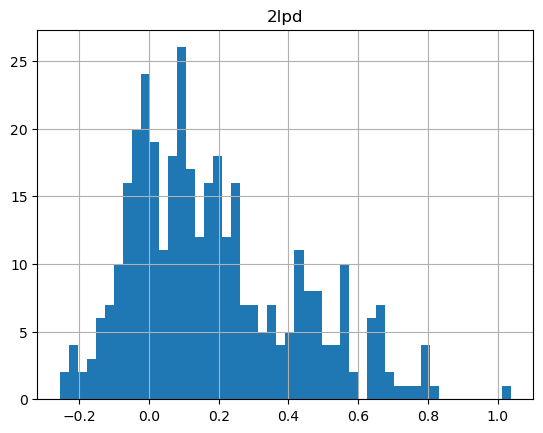

In [9]:
# plot histograms
beta_vals.hist('2lpd',bins=50)